## Define a Self-Organising Map Class

In [2299]:
import numpy as np
import math as m
from matplotlib import pyplot as plt
from numpy.linalg import norm
from IPython.display import clear_output

class SelfOrganisingMap:
    
    def __init__(self, dimX, dimY, dimW, sigma=5, eta=5):
        
        self.grid = np.random.rand(dimX, dimY, dimW)
        self.gauss = np.vectorize(np.vectorize(lambda x,mu,sigma: 1. / m.sqrt(2. * sigma * m.pi) * m.exp(-(x-mu) ** 2. / (2.*sigma))))
        self.sigma = sigma
        self.eta = eta
        
    # returns the row / column indicies of the best matching unit for a given datapoint
    def getBMU(self, x):
        
        idx = np.linalg.norm(self.grid - x, axis = 2).argmin()
        return idx / self.grid.shape[1], idx % self.grid.shape[1]
    
    def getBMUDist(self, x):
        
        return np.linalg.norm(x-self.grid[self.getBMU(x)])
    
    # returns an array representing the distance of each cell from the given row/col
    def dist(self, row, col):
        
        rows = abs(np.arange(self.grid.shape[0]*self.grid.shape[1]).reshape([self.grid.shape[0],self.grid.shape[1]]) / self.grid.shape[1] - row)
        cols = abs(np.arange(self.grid.shape[0]*self.grid.shape[1]).reshape([self.grid.shape[0],self.grid.shape[1]]) % self.grid.shape[1] - col)

        return np.sqrt(np.power(rows,2) + np.power(cols,2))

    def update(self,x):
        
        # get the best matching unit
        r,c = self.getBMU(x)
        
        # now see how much we need to correct all the units around the BMU
        alpha = self.gauss(self.dist(r,c),0,self.sigma)
        
        # add a new axis onto alpha so we can braodcast it onto all layers of the grid
        alpha = alpha[:,:, np.newaxis]

        # now calculate exactly how much to add to each of the neighbouring units
        delta = alpha * (x - self.grid)
        
        # lastly update the grid
        self.grid += (delta * self.eta)

## Test the Update Process

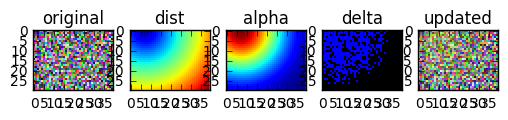

In [2165]:
som = SelfOrganisingMap(30,40,3,200,10)

x = [0.9, 0.95, 0.1]

r,c = som.getBMU(x)

plt.subplot(1, 5, 1)
plt.title("original")
plt.imshow(som.grid,interpolation='none')

plt.subplot(1, 5, 2)
plt.title("dist")
plt.imshow(som.dist(r,c),interpolation='none')

plt.subplot(1, 5, 3)
plt.title("alpha")
alpha = som.gauss(som.dist(r,c),0,som.sigma)
plt.imshow(alpha,interpolation='none')

plt.subplot(1, 5, 4)
plt.title("delta")
alpha = alpha[:,:, np.newaxis]
delta = alpha * (x - som.grid)
plt.imshow(delta,interpolation='none')

plt.subplot(1, 5, 5)
plt.title("updated")
som.grid += delta * som.eta
plt.imshow(som.grid,interpolation='none')

plt.show()

## Test a Batch Update

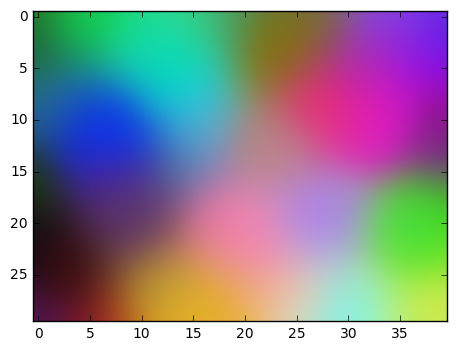

In [1366]:
som = SelfOrganisingMap(30,40,3,10,5)

batch = [np.random.rand(3) for _ in range(400)]

for x in batch:
    som.update(x)

plt.imshow(som.grid)
plt.show()

## Import the Photos from their Folder

In [2479]:
import os
import scipy.misc as misc

class Photo:
    def __init__(self, filepath):
        
        self.filepath = filepath
        self.coords = []
        self.shape = []
        self.placed = False

        img = misc.imread(filePath)
        self.aspectRatio = [3,4] if img.shape[0] < img.shape[1] else [4,3]
        self.val = misc.imread(filePath).mean(axis=(0,1))[:3]; self.val /= 255.

photos = []
        
directory = os.path.join(os.getcwd(),'preprocessed')

for f in os.listdir(directory):
    filePath = os.path.join(directory, f)
    photos.append(Photo(filePath))

## Now take each of the photos and cluster them with the SOM

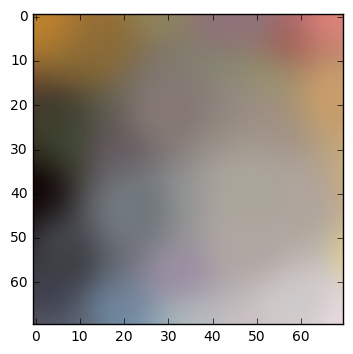

In [2481]:
som = SelfOrganisingMap(70,70,3,50,20) #(9,12,3,3,5)

for photo in photos:
    som.update(photo.val)

plt.imshow(som.grid)
plt.show()

## The photos don't end up evenly spaced on the SOM so we define a class to lay them out as a patchwork

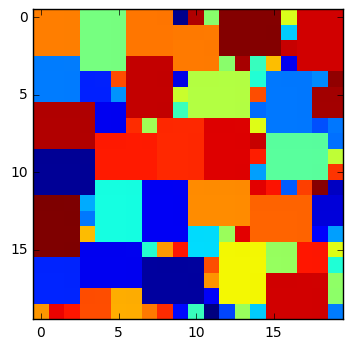

In [2482]:
class Patchworker:
    def __init__(self, size):
        self.occupied = np.zeros(size)        
    
    def Reset(self):
        self.occupied.fill(0)
    
    def Full(self):
        return np.prod(patch.occupied.shape) - np.count_nonzero(patch.occupied) == 0

    def AddPatch(self, coords, shapes):
        
        for shape in shapes:
            for rowOffset in range(1 - shape[0], 1):
                for colOffset in range(1 - shape[1], 1):

                    shiftedCoords = np.add(coords, (rowOffset, colOffset))

                    if self.CheckFit(shiftedCoords, shape):
                        self.occupied[shiftedCoords[0] : shiftedCoords[0] + shape[0], shiftedCoords[1] : shiftedCoords[1] + shape[1]] = random.randint(0,255)
                        return shiftedCoords, shape

                    
    # returns true if the patch fits in the specified spot in the patchwork
    def CheckFit(self, coord, shape):

        # return false if the coord is out of bounds
        if coord[0] + shape[0] > self.occupied.shape[0] or coord[1] + shape[1] > self.occupied.shape[1] or coord[0] < 0 or coord[1] < 0:
            return False

        place = np.zeros(self.occupied.shape)
        place[coord[0] : coord[0] + shape[0], coord[1] : coord[1] + shape[1]] = 1

        return ~np.any(self.occupied * place)


# test it out!
patch = Patchworker((20,20))

while not patch.Full():
    
    empties = np.where(patch.occupied==0)
    choice = random.randint(0,len(empties[0])-1)
    targetCoord = (empties[0][choice], empties[1][choice])

    coord, shape = patch.AddPatch(targetCoord, [[3,4] if random.randint(0,1) else [4,3], [3,3], [2,2], [1,1]])

plt.imshow(patch.occupied,interpolation='none')
plt.show()

In [2404]:
# returns the row / column indicies of the best matching unit for a given datapoint
def getPhotoCoord(val, grid, occupancy):
    idx = np.linalg.norm((grid + occupancy[:,:,np.newaxis] * 10000) - val, axis = 2).argmin()
    return idx / grid.shape[1], idx % grid.shape[1]

def getPhotoMatch(val, grid, occupancy):
    return np.linalg.norm(val - grid[getPhotoCoord(val,grid,occupancy)])

repeat
repeat


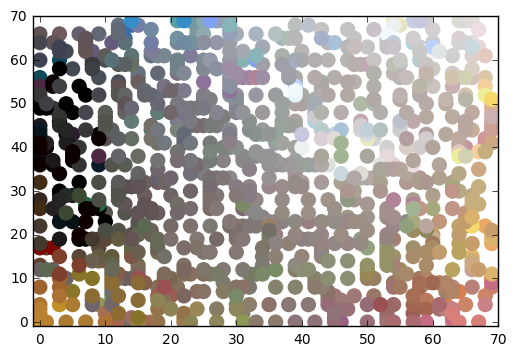

In [2495]:
import PIL.Image
import scipy

patch = Patchworker(som.grid.shape[:2])

for photo in photos:
    photo.coords = []
    photo.shape = []
    photo.placed = False
    
while not patch.Full():

    # find the photo which best matches it's BMU
    unusedPhotos = [photo for photo in photos if photo.placed == False]

    if not len(unusedPhotos):       
        for photo in photos:
            photo.placed = False
        print 'repeat'
        continue
    
    idMin = np.array([getPhotoMatch(photo.val, som.grid, patch.occupied) for photo in unusedPhotos]).argmin()
    BMP = unusedPhotos[idMin]

    targetCoords = getPhotoCoord(BMP.val, som.grid, patch.occupied)
    coords, shape = patch.AddPatch(targetCoords, [BMP.aspectRatio, [3,3], [2,2], [1,1]])
    BMP.coords.append(coords)
    BMP.shape.append(shape)
    BMP.placed = True

colors = []; coords = []

for photo in photos:
    for coord in photo.coords:
        coords.append(coord)
        
    for coord in photo.coords:
        colors.append(photo.val)

coordArr = np.array(coords).astype(float)

plt.xlim(-1, som.grid.shape[1])
plt.ylim(-1, som.grid.shape[0])
plt.scatter(coordArr[:,1], coordArr[:,0],color=colors,s=100)
plt.show()

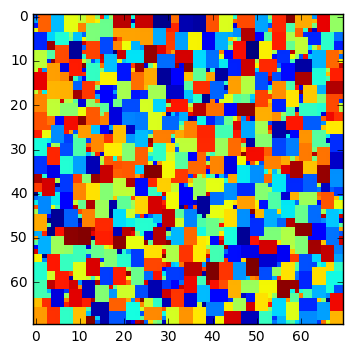

In [2496]:
plt.imshow(patch.occupied,interpolation='None')
plt.show()

## And render them to an image

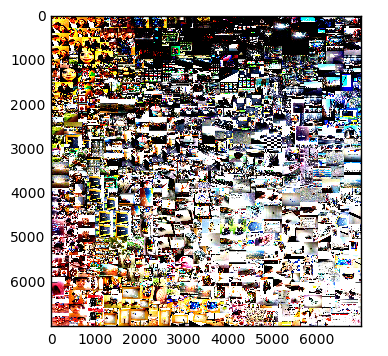

In [2503]:
import PIL.Image
import PIL.ImageDraw

canvas = PIL.Image.new("RGB", np.multiply(som.grid.shape[:2], 100), "white")

for photo in photos:
    img = PIL.Image.open(photo.filepath)

    for i in range(len(photo.coords)):
        sizeTup = tuple(np.multiply(photo.shape[i],100))
        coordTup = tuple(photo.coords[i] * 100)
        
        #if sizeTup[0] == sizeTup[1]:

        canvas.paste(img.resize(sizeTup,PIL.Image.NEAREST), coordTup)
        
plt.imshow(canvas)
plt.show()